# Image-Classifier-TensorFlow-Demo

In this demonstration I will train an image classifier using the PyTorch Framework to classify 102 species of flowers. For training I will be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. You can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

In [29]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image
import numpy as np
import time
import json

# Use GPU if it's available, else use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run autotuner to select kernel with best peroformance
torch.backends.cudnn.benchmark = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. You can [download the dataset here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(224, scale=(0.5, 1.5)),
                                       transforms.ColorJitter(brightness=0.03, hue=0.03),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_test_transforms = transforms.Compose([transforms.Resize(224), 
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)

valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_test_transforms)

test_data = datasets.ImageFolder(data_dir + '/test', transform=valid_test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)

validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=False, num_workers=6, pin_memory=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=6, pin_memory=True)

### Label mapping

We'll need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the model and classifier

Now that the data is ready, it's time to build and train the classifier. We will be using one of the pretrained models from `torchvision.models` to get the image features. Many pretrained classification models are available and can be found [here](https://pytorch.org/vision/stable/models.html). We will need to:

* Load a pretrained network and freeze the models weights
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we will only be updating the weights of the new classifier we build while using the weights of the pretrained model to detect image features. We will then try some hyperparameter combinations (learning rate, units in the classifier, epochs, etc) to see if we can increase the model validation accuracy.

First I will define some functions and a class to help build the classifier and train the model.

In [16]:
# Load pretrained weights
weights='IMAGENET1K_V1'

# Load model using pretrained weights
model = models.maxvit_t(weights=weights)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [8]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float, dropout probability
        '''
        super().__init__()
        
        self.drop_p = drop_p
        
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = F.dropout(x, self.drop_p)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [9]:
def train(model, trainloader, validloader, criterion, optimizer, epochs=10, scheduler=None):
    ''' Trains the model on training data for number of epochs
    
        Arguments
        ---------
        model: model to train
        trainloader: training data loader
        validloader: validation data loader
        criterion: loss function
        optimizer: optimizer to update model parameters
        epochs: number of epochs to train the model
        scheduler: learning rate scheduler
    
    '''
    # Loss and Accuracy variables are global for plotting and comparing
    global train_losses
    global validation_losses
    global validation_accuracy
    
    train_losses, validation_losses, validation_accuracy = [], [], []
         
    # Move model to GPU if available, else CPU is used
    model.to(device) 
       
    # Loop over epochs
    for epoch in range(epochs):
        
        # Start timer
        start = time.time() 
        
        # Set the model to training mode
        model.train()
        
        # Keep track of training epoch loss rate
        running_loss = 0 

        # Get our data
        for images,labels in trainloader:

            # Move image and label tensors to the default device
            images, labels = images.to(device), labels.to(device)

            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()

            # Forward pass, then backward pass, then update weights
            log_ps = model.forward(images) # Forward Pass. Ouputs log probabilities
            loss = criterion(log_ps, labels) # Calculate Loss
            loss.backward() # Backpropagation
            optimizer.step() # Update Weights        
            running_loss += loss.item() # Accumulate training loss

        else: # After all training batches in current epoch are complete

            # Update learning rate if scheduler is supplied
            if scheduler:
                scheduler.step() 

            # Turn off gradients to speed up this part
            with torch.no_grad():

                # Set model to evaluation mode/ inference mode. Turns off dropout
                model.eval()

                # Keep track of validation loss and accuracy
                validation_loss = 0
                accuracy = 0

                # Validation pass here
                # Loop over validation data
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)

                    log_ps = model.forward(images) # Forward Pass. Ouputs log probabilities
                    batch_loss = criterion(log_ps, labels) # Calculate Loss
                    validation_loss += batch_loss.item() # Accumulate validation loss

                    # Calculate accuracy
                    ps = torch.exp(log_ps) # Exponential of log probabilities for each class
                    top_p, top_class = ps.topk(1, dim=1) # Get top 1 predictions
                    equals = top_class == labels.view(*top_class.shape) # Compare prediction with ground truth
                    accuracy += torch.mean(equals.type(torch.FloatTensor)) # Accumulate accuracy scores

            # Get mean loss to enable comparison between train and validation sets
            train_losses.append(running_loss/ len(trainloader))
            validation_losses.append(validation_loss/ len(validloader))

            # Get mean validation accuracy
            validation_accuracy.append(accuracy/ len(validloader))

            if (epoch+1) == 1 or ((epoch+1) % 5) == 0: # Print 1st and every 5 epochs
                print(f"Epoch {epoch+1}/{epochs}, "
                      f"Time per epoch: {time.time() - start:.2f} seconds, "
                      f"Training Loss: {train_losses[-1]:.4f}, "
                      f"Validation Loss: {validation_losses[-1]:.4f}, "
                      f"Validation accuracy: {validation_accuracy[-1]:.4f}")
                
             # Set the model to training mode
            model.train()    
            
    print(f"Final Epoch {epoch+1}/{epochs}, Validation accuracy: {validation_accuracy[-1]:.4f}")               

In [17]:
# Hyperparameter Dictionary
hyperparameters = {0: {'hidden_units':[1024], 'learning_rate':0.001},
                   1: {'hidden_units':[1024], 'learning_rate':0.003},
                   2: {'hidden_units':[1024,512], 'learning_rate':0.001},
                   3: {'hidden_units':[1024,512], 'learning_rate':0.003},
                   4: {'hidden_units':[512], 'learning_rate':0.001},
                   5: {'hidden_units':[512], 'learning_rate':0.003}}

In [10]:
# List to hold each hyperparameter combos best validation accuracy
best_validation_accuracies = []

epochs = 15

# Loop through hyperparameter combinations
for i in range(len(hyperparameters)):
    hidden_layers, learning_rate = hyperparameters[i]['hidden_units'], hyperparameters[i]['learning_rate']
    
    # Print current hyperparameters
    print(f"\nCurrent Training Hyperparameters: Hidden_layer_Size(s): {hidden_layers}, Learning_Rate: {learning_rate}")
    
    # Define new classifier
    new_classifier = Network(512, 102, hidden_layers, drop_p=0.1)
    
    # Replace pretrained model output classifier layer[5] with newly created classifier
    model.classifier[5] = new_classifier
    
    # Define Loss Functions
    criterion = nn.NLLLoss() # Negative Log Likelihood Loss
    
    # Optimizer only updating new classifier layer[5] weights
    optimizer = optim.Adam(model.classifier[5].parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Train model using training function with hyperparameters
    train(model, trainloader, validloader, criterion, optimizer, epochs=epochs, scheduler=scheduler)
    
    # Best validation accuracy for this hyperparameter combination after completing all training epochs
    best_validation_accuracies.append(max(validation_accuracy))      
    
    print(f"Best current hyperparameter validation accuracy: {best_validation_accuracies[-1]:.4f}")
    
    # Save model if validation accuracy is the highest
    
    model_name = 'model_best_val_accuracy.pth'
    
    if best_validation_accuracies[-1] == max(best_validation_accuracies):
        best_hyperparamters =  hyperparameters[i] # Store hyperparameters for best validation accuracy
        print(f"\nSaving Model with Best Validation Accuracy over all hyperparameters: {best_validation_accuracies[-1]:.4f}"
              f"\nBest hyperparameters: {best_hyperparamters}"
              f"\nModel saved to: '{model_name}'\n")
        
        torch.save({'state_dict': model.state_dict(),
                    'classifier': model.classifier[5],
                    'optimizer_state_dict': optimizer.state_dict(),
                    'class_to_idx': train_data.class_to_idx
                    }, model_name)
        
print(f"\nDone Training!"
      f"\nBest Validation Accuracy over all hyperparameters: {max(best_validation_accuracies):.4f}"
      f"\nBest hyperparameters: {best_hyperparamters}"
      f"\nModel saved to: '{model_name}'")


Current Training Hyperparameters: Hidden_layer_Size(s): [1024], Learning_Rate: 0.001
Epoch 1/15, Time per epoch: 84.28 seconds, Training Loss: 2.1580, Validation Loss: 0.7415, Validation accuracy: 0.8394
Epoch 5/15, Time per epoch: 30.54 seconds, Training Loss: 0.1996, Validation Loss: 0.3235, Validation accuracy: 0.9154
Epoch 10/15, Time per epoch: 31.45 seconds, Training Loss: 0.1004, Validation Loss: 0.2228, Validation accuracy: 0.9437
Epoch 15/15, Time per epoch: 55.07 seconds, Training Loss: 0.0715, Validation Loss: 0.2332, Validation accuracy: 0.9368
Final Epoch 15/15, Validation accuracy: 0.9368
Best current hyperparameter validation accuracy: 0.9440

Saving Model with Best Validation Accuracy over all hyperparameters: 0.9440
Best hyperparameters: {'hidden_units': [1024], 'learning_rate': 0.001}
Model saved to: 'model_best_val_accuracy.pth'


Current Training Hyperparameters: Hidden_layer_Size(s): [1024], Learning_Rate: 0.003
Epoch 1/15, Time per epoch: 55.54 seconds, Training 

## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. We will run the test images through the network and measure the accuracy, the same way we did with validation.

In [19]:
# Test model on test dataset

# Load best validation accuracy model
model = load_checkpoint('model_best_val_accuracy.pth', optimizer=False) 

# Move model to GPU if available, else CPU is used
model.to(device)

# Turn off gradients to speed up this part
with torch.no_grad():

    # Set model to evaluation mode/ inference mode. Turns off dropout
    model.eval()

    # Keep track of test accuracy
    accuracy = 0

    # Loop over test data
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        log_ps = model.forward(images) # Forward Pass. Ouputs log probabilities

        # Calculate accuracy
        ps = torch.exp(log_ps) # Exponential of log probabilities for each class
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 predictions
        equals = top_class == labels.view(*top_class.shape) # Compare prediction with ground truth
        accuracy += torch.mean(equals.type(torch.FloatTensor)) 

# Get average accuracy
test_accuracy = (accuracy/ len(testloader))
             
print(f"Test dataset accuracy of model with best validation accuracy"
      f"\nTest Accuracy: {test_accuracy:.2f}")

Test dataset accuracy of model with best validation accuracy
Test Accuracy: 0.94


In [18]:
def load_checkpoint(filepath, optimizer=False):
    ''' Builds PyTorch Model from saved model
        Returns built model
        
        Arguments: string, filepath of saved PyTorch model
    '''
    
    # Load pretrained weights
    weights='IMAGENET1K_V1'

    # Load model using pretrained weights
    model = models.maxvit_t(weights=weights)
    
    # Load checkpoint
    checkpoint = torch.load(filepath)
    
    # Get new classifier from checkpoint
    new_classifier = checkpoint['classifier']
    
    # Replace pretrained model output classifier layer[5] with newly created classifier
    model.classifier[5] = new_classifier
    
    # Load model weights
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load optimizer weights
    if optimizer:
        optimizer = optim.Adam(model.classifier[5].parameters())
    
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load class to index mapping
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

## Save the checkpoint

Now that our network is trained, we will save the model so we can load it later for making predictions. We'll want to save things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [21]:
# Complete model with optimizer, hyperparameters, classifier, and class_to_idx was saved above while testing hyperparameters

# This model save is for inference only
model_name = 'inference_model.pth'

torch.save({'state_dict': model.state_dict(),
            'classifier': model.classifier[5],
            'class_to_idx': train_data.class_to_idx
            }, model_name)

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. I'll write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It will look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, we'll resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. We'll then need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expects floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [1]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array

        Arguments
        ---------
        image: path of the image to be processed
    '''
    image = Image.open(image) # Open image
    w, h = image.size # Get image size
    
    # resize image so shortest side is 256 preserving aspect ratio
    if w > h:
        image.thumbnail((10000, 256))
    elif h > w:
        image.thumbnail((256, 10000))
    else:
        image.thumbnail((256, 256))
        
    # crop center 224x224
    w, h = image.size
    left = (w - 224)//2
    top = (h - 224)//2
    right = (w + 224)//2
    bottom = (h + 224)//2
    image = image.crop((left, top, right, bottom))
    
    # Convert pil image to numpy array and scale color channels to [0, 1]
    np_image = np.array(image)/255
    
    # Normalize image
    mean = np.array([0.485, 0.456, 0.406]) # Mean 
    std = np.array([0.229, 0.224, 0.225]) # Stanard deviation
    np_image = (np_image - mean) / std
    
    # Move color channels to first dimension
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [2]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes its the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    if title:
        ax.set_title(title)
    
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)  
    
    ax.imshow(image)

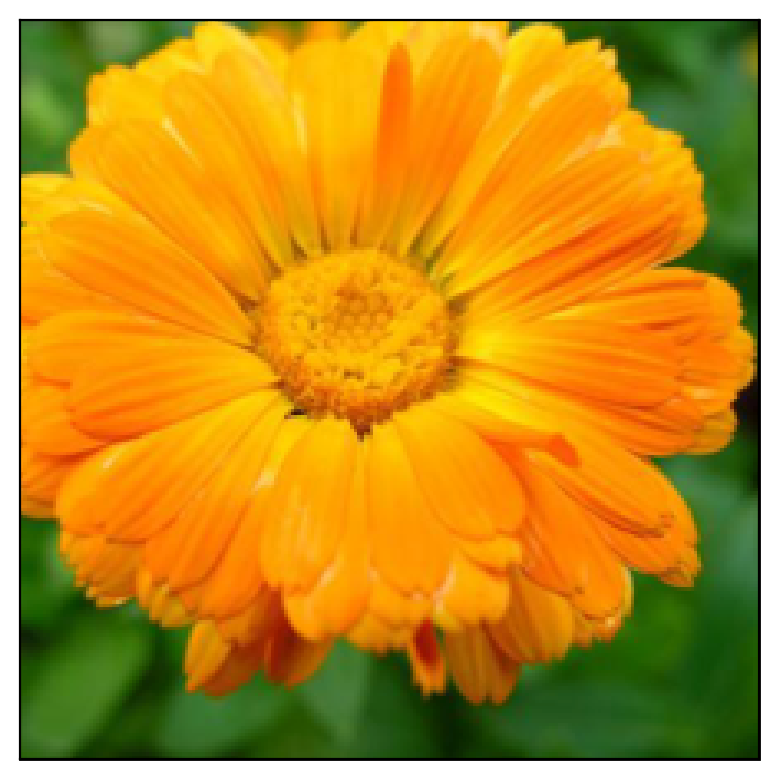

In [11]:
image = process_image('assets/test_image.jpg') # Load image
imshow(image) # Show image

## Class Prediction

Once the images are in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor, we'll use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which we added to the model  from the `ImageFolder` we used to load the data. We also need to make sure to invert the dictionary so we get a mapping from index to class as well.

In [41]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Arguments
        ---------
        image_path: path of the image to be processed
        model: model to be used for prediction
        topk: number of top predicted classes to return
    '''
    # Process image function
    image = process_image(image_path)
    
    # Convert image to float tensor with batch size of 1
    image = torch.as_tensor(image).view((1,3,224,224)).float()
    
    # Move image to GPU if available, else CPU is used
    image = image.to(device)
    
    # Move model to GPU if available, else CPU is used
    model.to(device)
    
    # Set model to evaluation mode/ inference mode
    model.eval()
        
    # Turn off gradients to speed up this part
    with torch.no_grad():
        
        # Forward Pass. Ouputs log probabilities of classes
        log_ps = model.forward(image)
        
        # Exponential of log probabilities for each class
        ps = torch.exp(log_ps)
        
        # Get top k predictions. Returns probabilities and class indexes
        top_probs, idx = ps.topk(topk, dim=1)
        
        # Convert tensors to lists. Index[0] returns unnested List
        top_probs, idx = top_probs.tolist()[0], idx.tolist()[0]

        # Convert top_probs to percentages
        percentages = [round(prob * 100.00, 2) for prob in top_probs]
        
        # Converts class_labels:indexes to indexes:class_labels
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        
        # get class labels from indexes
        top_labels = [idx_to_class[lab] for lab in idx]

        return percentages, top_labels

In [42]:
# Check that Predict function works as intended

# Load inference model
model = load_checkpoint('inference_model.pth', optimizer=False)

# Test function and print results
probs, classes =  predict('assets/test_image_2.jpg', model, topk=5)
print(probs)
print(classes)

[100.0, 0.0, 0.0, 0.0, 0.0]
['28', '3', '51', '43', '72']


## Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

We'll convert from the class:integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, we'll use the `imshow` function defined earlier.

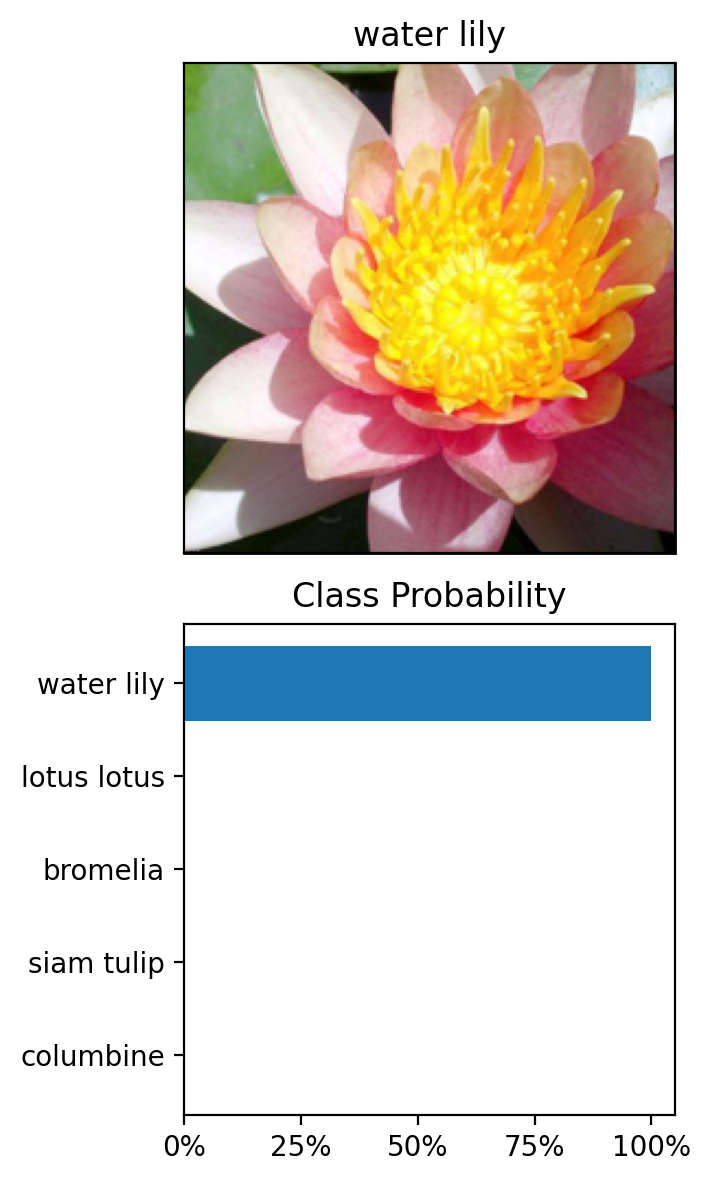

In [43]:
# Load saved inference model
model = load_checkpoint('inference_model.pth', optimizer=False)

# Display an image along with the top 5 classes
image_path = 'assets/water_lily.jpg'
probs, classes = predict(image_path, model, topk=5)

# plot bar chart of top 5 classes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,6))
image = process_image(image_path)
imshow(image, ax=ax1, title=cat_to_name[classes[0]])

classes = [cat_to_name[lab] for lab in classes]
ax2.barh(np.arange(len(classes)), probs)
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)
ax2.set_yticks(np.arange(len(classes)))
ax2.set_yticklabels(classes)
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(ticker.PercentFormatter())
ax2.set_title("Class Probability")
plt.tight_layout()
plt.show()

As we can see in the bar plot above, our trained model correctly predicted that the image of the flower is a water lily with high accuracy.

### Further Increasing Accuracy

Our current model has a 94% accuracy on the test dataset which is acceptable for the majority of cases, but let's see if we can push the accuracy a bit further. In this section, I will attempt this by training all the layers of the pretrained model along with the classifier. 

Since the pretrained model has already been trained on the enormous imagenet dataset and is a great image feature detector, we only want to nudge the parameters a tiny bit for our flower dataset. We will do this by adjusting the learning rate so the deeper blocks of layers in the pretrained model have consecutively lower learning rates. This will ensure the feature detector weights will only slightly be adjusted. This means near the output/classifier end of the model the learning rate will be higher, and near the beginning/input end of the model the learning rate will be very low.

In [44]:
import re

def lr_layer_multiplier(model, lr=1e-3, lr_mult=0.9, verbose=False):
    ''' Consecutively multiplies the learning rate(lr) of previous named layers or named blocks
        of layers in model parameters. 
        
        Arguments
        ---------
        model: PyTorch model, model layer's lr will be adjusted
        lr: float, lr of last layer of model
        lr_multi: float, multiply lr of deeper layers/block of layers by this number  
    '''
    global parameters
    
    # save layer names
    layer_names = []
    for idx, (name, param) in enumerate(model.named_parameters()):
        layer_names.append(name)
            
    # reverse layers
    layer_names.reverse()

    # placeholder
    parameters = []
    prev_group_name = layer_names[0].split('layers')[0]

    # store params & learning rates
    for idx, name in enumerate(layer_names):

        # parameter group name
        cur_group_name = name.split('layers')[0]
        
        # Search for Classifier Layers and do not update learning rate multiplier
        reg_ex = re.search(r"classifier", cur_group_name)
    
        if reg_ex:
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() \
                                       if n == name and p.requires_grad], 'lr':     lr}]
            
            prev_group_name = cur_group_name
            
            if verbose:
                print(f'{idx}: lr = {lr:.6f}, {name}')
                
            continue
        
        # update learning rate
        if cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name
                
        # display info
        if verbose:
            print(f'{idx}: lr = {lr:.6f}, {name}')

        # append layer parameters
        parameters += [{'params': [p for n, p in model.named_parameters() \
                                   if n == name and p.requires_grad], 'lr':     lr}]
    
    return parameters